<a href="https://colab.research.google.com/github/YenaChoi00/ML-Final-Project/blob/main/ResNet_basic_transfer_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [19]:
from torch.utils.tensorboard import SummaryWriter
# 텐서보드 로그를 저장할 디렉토리 지정
log_dir = './logs'
# SummaryWriter 객체 생성
writer = SummaryWriter(log_dir)

In [20]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [21]:
#하이퍼 파라미터 튜닝

CFG = {
    'IMG_SIZE':32, #이미지 사이즈
    'EPOCHS':20, #epoch
    'LEARNING_RATE':2e-2, #학습률
    'BATCH_SIZE':32, #배치사이즈
    'SEED':41, #시드
}

# **Data Loader**

In [22]:
transforms_cifar10 = transforms.Compose([transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                  
                                 ])

#transforms.RandomRotation(30),transforms.RandomHorizontalFlip()

# resize, normalize만 들어가게. augmentation은 test에 적용하면 안됨.
transforms_cifar10_test = transforms.Compose([transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

from torch.utils.data import random_split

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)

# Split trainset into train and validation sets
train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size
trainset, validset = random_split(trainset, [train_size, valid_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [23]:
'''
train_len=(int(len(datasets.CIFAR10) * 0.75))
val_len=int(len(datasets.CIFAR10) * 0.25)

train_batches=len(trainloader)
vali_batches=len(validloader)

print('total train imgs:',train_len,'/ total train bathcnes:', train_batches)
print('total valid imgs:',val_len,'/ total valid batches:', vali_batches)
'''

"\ntrain_len=(int(len(datasets.CIFAR10) * 0.75))\nval_len=int(len(datasets.CIFAR10) * 0.25)\n\ntrain_batches=len(trainloader)\nvali_batches=len(validloader)\n\nprint('total train imgs:',train_len,'/ total train bathcnes:', train_batches)\nprint('total valid imgs:',val_len,'/ total valid batches:', vali_batches)\n"

plane   dog  deer  ship


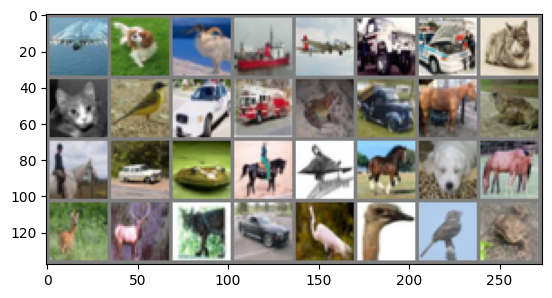

In [24]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

In [25]:
from tqdm import tqdm
import datetime

def train(model,optimizer,train_loader,scheduler,device):
  model.to(device)
  n=len(train_loader)
  best_loss=10000

  for epoch in range(1,CFG['EPOCHS']+1):  # 에포크 설정
    model.train()
    running_loss=0.0

    for img,label in tqdm(iter(train_loader)):
      img,label=img.to(device),label.to(device)
      optimizer.zero_grad() # 배치마다 optimzier 초기화

      logit=model(img)
      loss=criterion(logit,label)

      loss.backward()
      optimizer.step() # 가중치 최적화
      running_loss+=loss.item()

    print('[%d] Train loss: %.10f' %(epoch, running_loss/len(train_loader)))

    if scheduler is not None:
      scheduler.step()

    # validation set 평가
    model.eval() # evaluatoin 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
    vali_loss=0.0
    correct=0

    with torch.no_grad(): # 파라미터 업데이트 안하기 때문에 no_grad 사용
      for img,label in tqdm(iter(validloader)):
        img,label=img.to(device),label.to(device)

        logit=model(img)
        vali_loss+= criterion(logit,label)
        pred=logit.argmax(dim=1,keepdim=True)  # 10개의 class 중 가장 값이 높은 것을 예측 label로 추출
        correct += pred.eq(label.view_as(pred)).sum().item()  # 예측값과 실제값이 맞으면 1 아니면 0으로 합산
    vali_acc=100 * correct/len(validloader.dataset)

    print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(validloader), correct, len(validloader.dataset), 100 * correct / len(testloader.dataset)))
    '''
    if best_loss > vali_loss:
      best_loss=vali_loss

      # 현재 날짜와 시간을 문자열로 변환하여 파일 이름에 포함
      now = datetime.datetime.now()
      current_time = now.strftime("%Y%m%d_%H%M%S")

      # 파일 경로와 파일 이름을 조합하여 저장 경로 설정
      save_path = '/content/drive/MyDrive/daycon/'
      file_name = f"best_model_{current_time}.pth"
      file_path = os.path.join(save_path, file_name)

      # 모델 저장
      torch.save(model.state_dict(), file_path)

      print('Model Saved as %s' % file_name)
'''


# **Loss function and optimizer**

In [26]:
# Loss function and optimizer
'''
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
'''

'\nloss_fun = nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(net.parameters(), lr=0.001)\nscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)\n'

# **Train the network**

In [27]:
import torch.optim as optim
from tqdm.auto import tqdm
import torch.nn as nn
from torchvision import models

# 사전 학습 모델 가져오기
resnet=models.resnet50(pretrained=True).to(device)

for param in resnet.parameters(): # 모든 parameter 고정
  param.requires_grad=False

# 직전 layer의 출력값을 마지막 layer의 입력으로 맞춰줌
in_features=resnet.fc.in_features

classifier=nn.Sequential(
    nn.Linear(in_features,1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024,10),
)

# resnet의 마지막 layer를 내가 정의한 classifier로 바꿈
resnet.fc=classifier
'''
resnet=models.resnet50(pretrained=False).to(device)
'''
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=resnet.parameters(),lr=CFG['LEARNING_RATE'])
scheduler=None

resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
from torchsummary import summary
summary(resnet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [29]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
train(resnet, optimizer, trainloader, scheduler, device)

  0%|          | 0/1250 [00:00<?, ?it/s]

[1] Train loss: 1.7601779551


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.5142, Accuracy: 4814/10000 ( 48%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[2] Train loss: 1.5620951292


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.4565, Accuracy: 4978/10000 ( 50%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[3] Train loss: 1.5023041506


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.4129, Accuracy: 5106/10000 ( 51%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[4] Train loss: 1.4683545475


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3823, Accuracy: 5202/10000 ( 52%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[5] Train loss: 1.4351970059


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3576, Accuracy: 5336/10000 ( 53%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[6] Train loss: 1.4147419268


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3772, Accuracy: 5274/10000 ( 53%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[7] Train loss: 1.3989655664


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3331, Accuracy: 5348/10000 ( 53%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[8] Train loss: 1.3793619026


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3092, Accuracy: 5504/10000 ( 55%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[9] Train loss: 1.3635640103


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3534, Accuracy: 5364/10000 ( 54%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[10] Train loss: 1.3520288908


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3247, Accuracy: 5435/10000 ( 54%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[11] Train loss: 1.3430984725


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.2996, Accuracy: 5481/10000 ( 55%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[12] Train loss: 1.3307904000


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.2944, Accuracy: 5502/10000 ( 55%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[13] Train loss: 1.3210580757


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.2808, Accuracy: 5563/10000 ( 56%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[14] Train loss: 1.3065303909


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3041, Accuracy: 5512/10000 ( 55%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[15] Train loss: 1.2974323257


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3105, Accuracy: 5543/10000 ( 55%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[16] Train loss: 1.2904457392


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.2918, Accuracy: 5487/10000 ( 55%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[17] Train loss: 1.2833822998


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.2847, Accuracy: 5544/10000 ( 55%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[18] Train loss: 1.2746066782


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.2641, Accuracy: 5613/10000 ( 56%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[19] Train loss: 1.2666753958


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.2796, Accuracy: 5569/10000 ( 56%)



  0%|          | 0/1250 [00:00<?, ?it/s]

[20] Train loss: 1.2563503621


  0%|          | 0/313 [00:00<?, ?it/s]

Vail set: Loss: 1.3099, Accuracy: 5578/10000 ( 56%)



# **Validate the Network**

In [31]:
def predict(model,test_loader,device):
  model.eval()  #모델을 평가 모드로 설정
  model_pred=[]   # 예측값 저장

  with torch.no_grad(): # 기울기 계산을 비활성화 (모델의 파라미터 업데이트를 방지하여 예측 과정에서 메모리를 절약하고 속도를 향상)
    for img in tqdm(iter(test_loader)): # 테스트 데이터로 구성된 데이터로더인 test_loader에서 이미지를 반복적으로 가져옴
      img=img.to(device)

      pred_logit=model(img)
      pred_logit=pred_logit.argmax(dim=1,keepdim=True).squeeze(1) # 예측 로짓의 가장 큰 값을 가진 클래스를 선택하여 예측된 라벨로 변환
      model_pred.extend(pred_logit.tolist())    # 예측된 라벨을 model_pred 리스트에 추가

  return model_pred # 모든 예측된 라벨이 저장된 model_pred 리스트를 반환

In [32]:
import datetime

# 현재 날짜와 시간을 문자열로 변환하여 파일 이름에 포함
now = datetime.datetime.now()
current_time = now.strftime("%Y%m%d_%H%M%S")

# 파일 경로와 파일 이름을 조합하여 저장 경로 설정
save_path = '/content/drive/MyDrive/daycon/'
file_name = f"best_model_{current_time}.pth"
file_path = os.path.join(save_path, file_name)

checkpoint=torch.load(file_path)
Predictor=resnet.to(device)
Predictor.load_state_dict(checkpoint)

preds=predict(Predictor,testloader,device)
preds[0:5]    # 테스트 데이터의 첫 5개 샘플에 대한 예측값

FileNotFoundError: ignored

# **Test the network**

In [1]:
# Test the trained model with overall test dataset

correct = 0
total = 0

class_labels = [] # 각 이미지의 실제 클래스 레이블을 저장
class_preds = [] #모델의 예측 결과인 클래스 확률을 저장

for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = resnet(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)
    
    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()


# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))

## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 11 %

NameError: ignored